# 10. Uso de modelos de terceros

## Cloudflare AI Workers

Cloudflare AI workers es una de las maneras más fáciles y rápidas de desplegar modelos relevantes de la actualidad a costo 0 y con un tier gratuito bastante generoso de uso diario. Con esta herramienta, puede desplegar [modelos](https://developers.cloudflare.com/workers-ai/models/) de todo tipo de áreas, como los de generación de texto, traducción, generación de imágenes, y transformación de voz a texto.

### Creando un AI Worker

En este caso se usará el dashboard de Cloudflare por seguridad de mi cuenta, pero mi recomendación sería hacerlo en local con uso de C3, el CLI de Cloudflare, pues así dispondrá de mejor control de la implementación y podrá probar y hacer cambios en local sin desplegar.

En primer lugar, cree una cuenta y la verifica. Ya una vez en el dashboard, va a la sección de `Workers & Pages` y selecciona `Create Application`.

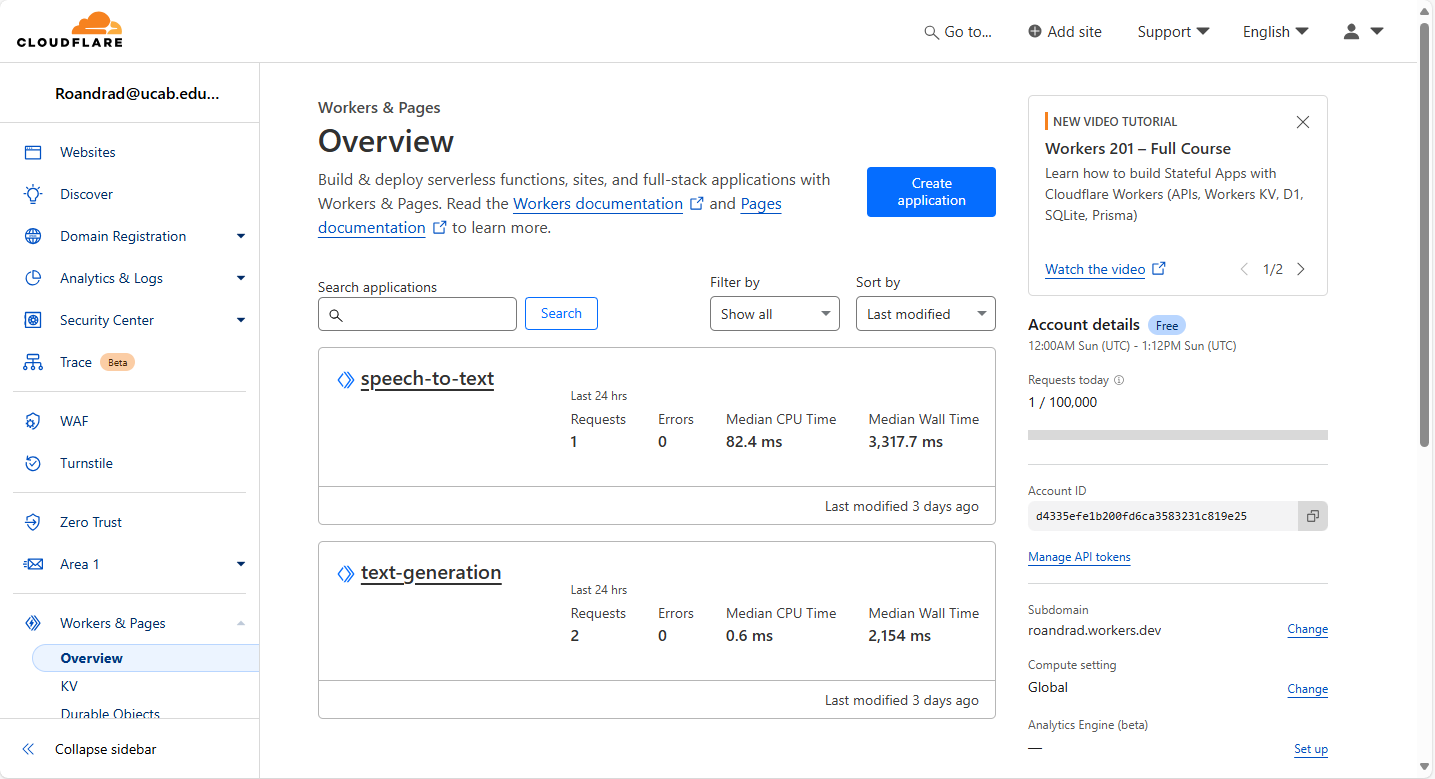

Se le abre una ventana con varias opciones, usted selecciona el tipo de modelo que desee. En este caso elegiremos un modelo LLM para generar texto.

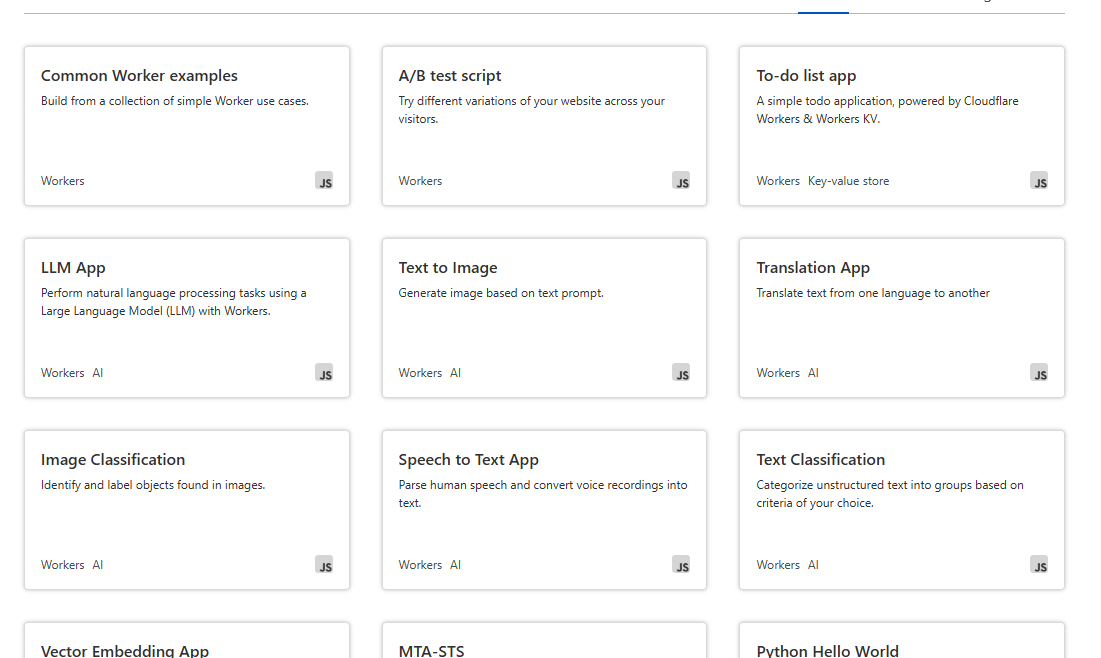

Ya una vez elegido se le introduce un nombre y se da click a `Deploy` para crear un worker. Un worker básicamente levanta una API dónde se devuelve una respuesta. Por defecto, el template lo que hace es mostrar los dos tipos de generación de texto que existen (generación y chat). Como es posible que el funcionamiento por defecto no nos sirva, lo siguiente a hacer es editar el código para hacer las funcionalidades que esperamos, para ello le damos a editar código.

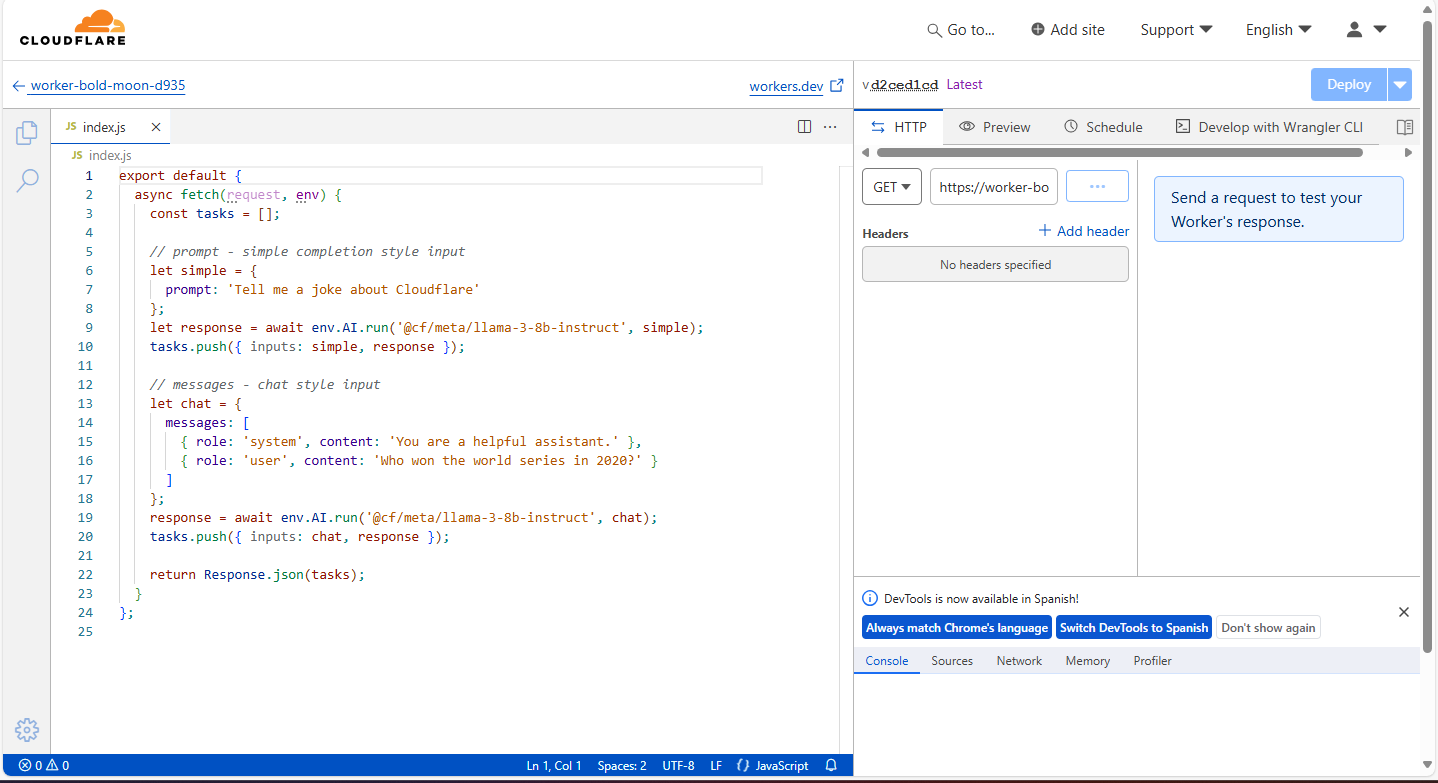


Editamos nuestro código, probamos y le damos a desplegar y así tendríamos nuestro worker funcionando. NADA impide usar varios AI bindings para usar el mismo worker para varias tareas como convertir voz a texto, luego generar texto a partir de ese texto, y luego llamar a una API de generación de voz para que el texto generado devuelva una respuesta hablada, a su vez la mayoría de modelos de cloudflare admiten el streaming de datos, por lo que puede empezar a generar texto o voz sin terminar la subida o bajada, o predicción de secuencias de texto.

Nuevamente, todos estos pasos se podían hacer de manera automática con C3 de cloudflare.


### Uso de nuestros workers

#### Generación de texto

Creamos un historial local de solicitudes de `user` y respuestas de `assistant`. Vamos a mandar el historial de mensajes al worker desplegado y mostraremos su respuesta. Adicionalmente añadiremos tanto la solicitud como la respuesta al historial.

**Importante** Si usa una suscripción de pago, le recomiendo agregar autenticación para evitar perder dinero si alguien descubre su dominio y empieza a hacer solicitudes sin su permiso.

In [ ]:
%%javascript

// Se está usando el worker directamente, pero les recomendaría hacer una API
// con Hono u otra librería similar
export default {
  async fetch(request, env) {
    if (request.method != 'POST') return Response.json('Invalid method');
    const {messages} = await request.json()

    let chat = {
      messages: [
        { role: 'system', content: 'You are a helpful assistant.' }, // En system ponemos todas las instrucciones del sistema.
        ...messages // Agregamos el histórico de mensajes del usuario
      ]
    };
    const response = await env.AI.run('@cf/meta/llama-3-8b-instruct', chat); // Usaremos llama-3-8b-instruct

    return Response.json(response);
  }
};

In [ ]:
import requests

url = 'https://text-generation.roandrad.workers.dev/'
chat_history = []

def chat(prompt: str):
  chat_history.append({
      'role': 'user',
      'content': prompt
  })
  response = requests.post(url, json={
      "messages": chat_history
  })
  r = response.json()
  answer = r['response']
  chat_history.append({ 'role': 'assistant', 'content': answer })
  return answer


In [ ]:
print(chat_history)
a = chat('Hola! Hablemos un rato')
print(a)

[]
¡Hola! Me alegra que quieras hablar un rato. Estoy aquí para escucharte y ayudarte en lo que necesites. ¿De qué quieres hablar? ¿Tienes algún tema en particular en mente o simplemente quieres charlar un poco? Estoy completamente a tu disposición.


#### Voz a texto

Para este caso, se implementó el worker para recibir blobs de audio, por lo que se enviará un blob, pero usted puede mandar streams, urls, o lo que crea necesario con el fin de lograr el correcto funcionamiento de su worker.

In [ ]:
!wget https://github.com/Azure-Samples/cognitive-services-speech-sdk/raw/master/samples/cpp/windows/console/samples/enrollment_audio_katie.wav

--2024-06-02 13:41:06--  https://github.com/Azure-Samples/cognitive-services-speech-sdk/raw/master/samples/cpp/windows/console/samples/enrollment_audio_katie.wav
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Azure-Samples/cognitive-services-speech-sdk/master/samples/cpp/windows/console/samples/enrollment_audio_katie.wav [following]
--2024-06-02 13:41:07--  https://raw.githubusercontent.com/Azure-Samples/cognitive-services-speech-sdk/master/samples/cpp/windows/console/samples/enrollment_audio_katie.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587016 (573K) [audio/wav]
Saving to: ‘enrollm

In [ ]:
%%javascript

// Se está usando el worker directamente, pero les recomendaría hacer una API
// con Hono u otra librería similar

export default {
  async fetch(request, env) {
    if (request.method != 'POST') return Response.json('Invalid method');
    const blob = await request.blob() // leemos un blob enviado en la request

    const inputs = {
      audio: [...new Uint8Array(await blob.arrayBuffer())]
    };
    const response = await env.AI.run('@cf/openai/whisper', inputs); // usamos whisper

    return Response.json({ inputs, response });
  }
};

In [ ]:
import requests

url = 'https://speech-to-text.roandrad.workers.dev/'

def speech_to_text(audio: str):
  # Lee el archivo de audio como un stream de bytes
  with open(audio, 'rb') as audio_file:
    audio_bytes = audio_file.read()

  # Los envía al worker
  response = requests.post(url, data=audio_bytes)

  r = response.json()
  answer = r['response']['text']
  return answer

In [ ]:
response = speech_to_text('enrollment_audio_katie.wav')
response

'Hello, it is a good day for me to teach you the sound of my voice. You have learned what I look like now you can hear what I sound like. The sound of my voice will help the transcription service to recognize my unique voice in the future. Training will provide a better experience with greater accuracy when talking or dictating. Thank you and goodbye.'

### Tu turno

Intenta crear un worker para la generación de texto a imagen y que esa imagen luego la pase por otro modelo de clasificación de imágenes.

## Azure ML Studio

Pese a que es pago como la mayoría de servicios, gracias a GitHub Students pack y convenios de la universidad, usted dispone de $100 de créditos en Azure que le permiten experimentar con la mayoría de funcionalidades, entre ellas, Azure ML studio.

En Azure ML Studio usted puede desplegar cualquier modelo de IA, y a su vez dispone de un amplio catálogo de modelos existentes, sin la necesidad de pagar nada.

Lo primero que debe hacer es crear un recurso de AzureML studio e ir al dashboard de ML Studio. De allí va a `Catalog` y selecciona el modelo que desea desplegar.

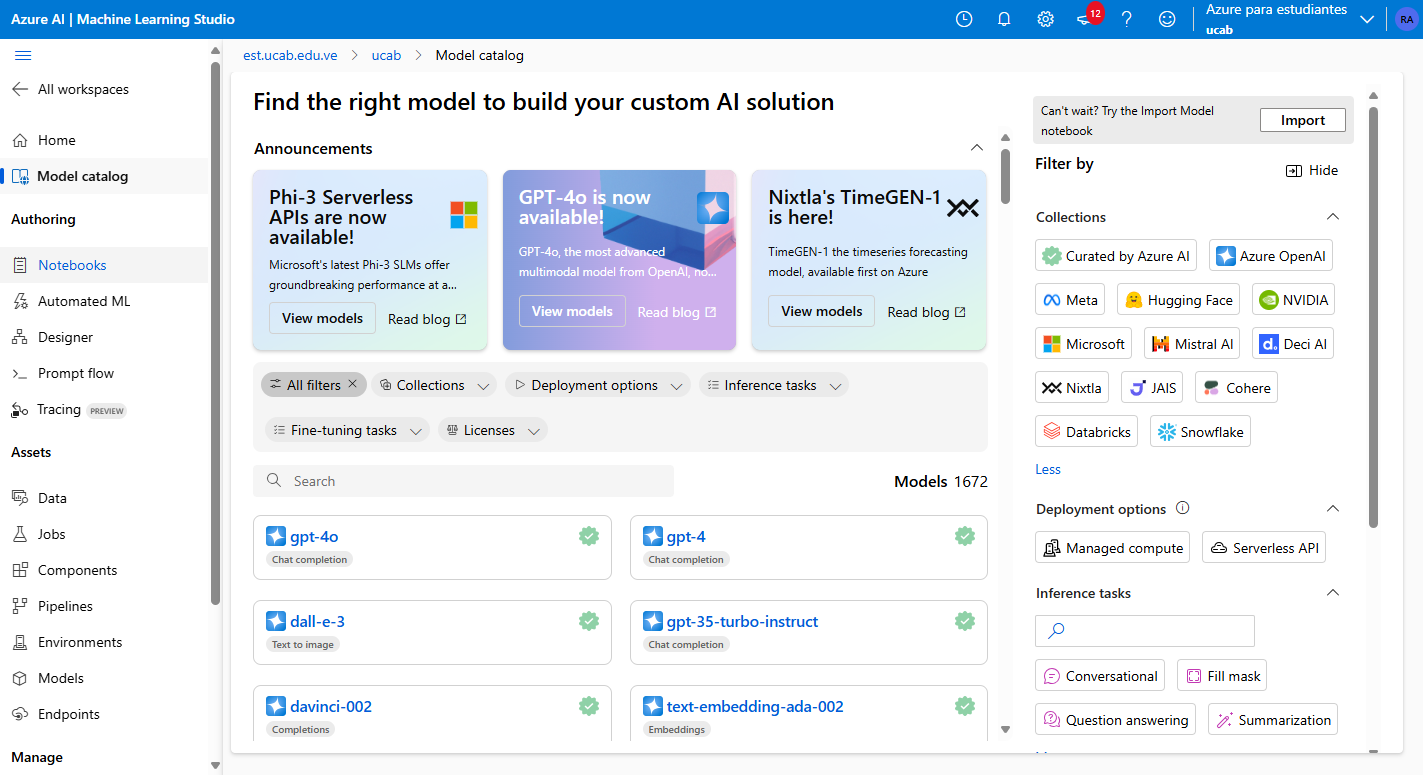

Por motivos regulatorios absurdos, no se puede usar ningún modelo de OpenAI con una cuenta registrada en Venezuela, no obstante, varios otros modelos sí están disponibles. Por ejemplo para generación de texto tenemos Phi de Microsoft.

Al seleccionar el modelo, leemos el resumen para verificar que es el modelo que queremos, cómo se usa, y si todo está bien le damos a desplegar.

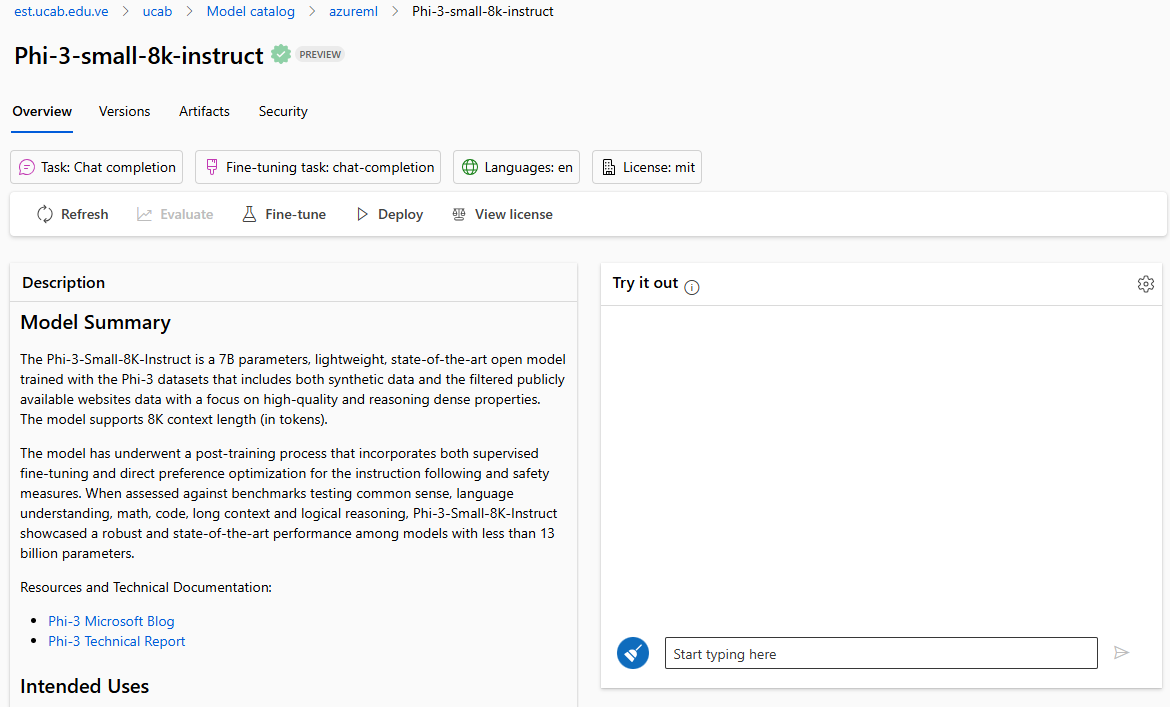

Posiblemente no tenga accesso a cuota para un servidor privado, pero puede solicitarla en soporte, o usar un servidor compartido (recomendado).

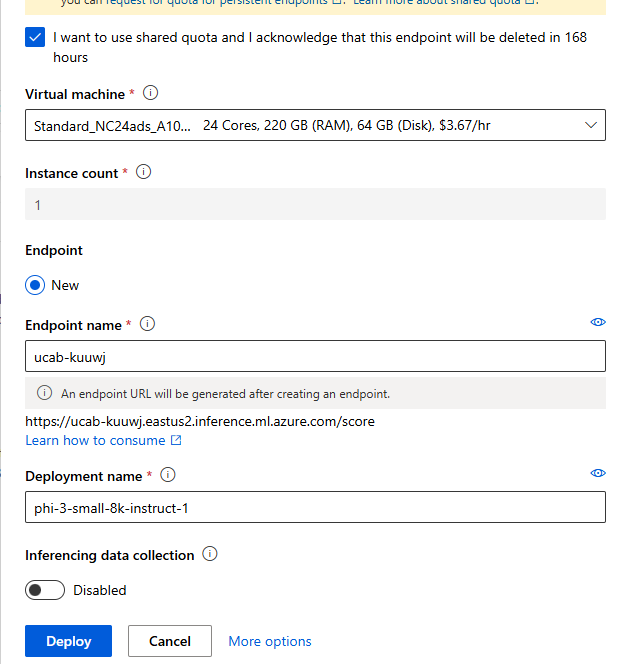

Ya una vez introduzca los datos del servicio a desplegar como nombre del endpoint y otras opciones, le da a `Deploy` y su endpoint estará desplegado.

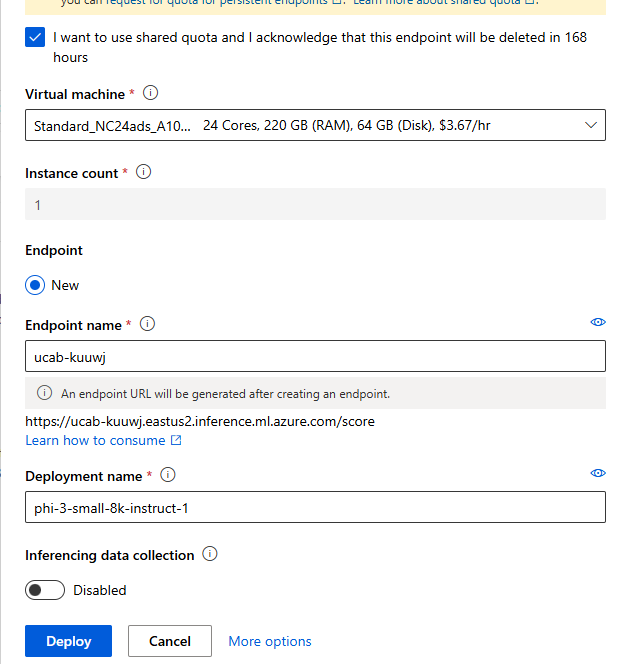


Tenga cuidado porque se cobra por hora, desactive el modelo una vez no lo use más.

## Proveedores baratos pero que requieren tarjeta de crédito o VPN

### OpenAI

- Bastante barato y tiene todo tipo de modelos. Su modelo de compra de créditos evita sobre costes indeseados.

- No se puede usar legalmente desde Venezuela. Necesita VPN y un número de teléfono del exterior.

### Vertex

- Servicio de IA de Google con disponibilidad cercana al 100%.
- No se puede crear cuenta de GCP venezolana, pero nada le impide usar otro país. Vertex no está disponible en Europa aunque se puede acceder por otras vías desde el dashboard de GCP.

### Hugging Face + Inference Endpoints + AWS

- Hugging Face permite desplegar casi todos sus modelos en una máquina virtual AWS con precios relativamente bajos. Adicionalemnte permite ahorrase la comisión de Hugging Face permitiendo desplegar directamente por SageMaker.

- No hay créditos de ningún tipo, pago por uso de inmediato.

### AWS

- El  mejor competidor de Cloudflare en el área, junto a la posibilidad de pedir créditos y disponibilidad para Venezuela lo hace muy atractivo.

- Debes solicitar a soporte que te suban la capacidad de cómputo manualmente y no deja usar servidores con GPU para correr modelos de ningún tipo hasta que lleves un tiempo en la plataforma, supuestamente para evitar costos imprevistos.